In [1]:
import torch, torch.nn as nn

In [2]:
from Models.sequential import Sequential_Model
from Layers.linear import LinearLayer
from Activations.relu import relu
from Activations.sigmoid import sigmoid
from Loss_Func.log_loss import log_loss
from Metrics.acc import accuracy

In [3]:
#Model Architecture

d_in = 10
d_h = 4
d_o = 1

In [11]:
#Random Data
x_rand = torch.normal(0,1,(d_in,10))
y_rand = torch.sum(x_rand, dim=0)
y_rand = (y_rand>0).to(x_rand.dtype)

In [12]:
y_rand.shape

torch.Size([10])

In [5]:
model = Sequential_Model([LinearLayer(d_in,d_h),
                          relu(),
                          LinearLayer(d_h,d_o),
                          sigmoid()], log_loss)

In [9]:
epochs = 1000
loss_history = []
acc_history = []

for i in range(epochs):
    preds = model.forward_pass(x_rand)
    print(preds, y_rand)
    loss = model.loss_calc(y_rand, preds)
    model.backward_pass()
    model.step(1e-3)
    
    loss_history.append(loss)
    acc_history.append(accuracy(y_rand, preds))

tensor([[0.8311]]) tensor([1.])
tensor([[0.8313]]) tensor([1.])
tensor([[0.8315]]) tensor([1.])
tensor([[0.8316]]) tensor([1.])
tensor([[0.8318]]) tensor([1.])
tensor([[0.8320]]) tensor([1.])
tensor([[0.8322]]) tensor([1.])
tensor([[0.8324]]) tensor([1.])
tensor([[0.8325]]) tensor([1.])
tensor([[0.8327]]) tensor([1.])
tensor([[0.8329]]) tensor([1.])
tensor([[0.8331]]) tensor([1.])
tensor([[0.8332]]) tensor([1.])
tensor([[0.8334]]) tensor([1.])
tensor([[0.8336]]) tensor([1.])
tensor([[0.8338]]) tensor([1.])
tensor([[0.8340]]) tensor([1.])
tensor([[0.8341]]) tensor([1.])
tensor([[0.8343]]) tensor([1.])
tensor([[0.8345]]) tensor([1.])
tensor([[0.8346]]) tensor([1.])
tensor([[0.8348]]) tensor([1.])
tensor([[0.8350]]) tensor([1.])
tensor([[0.8352]]) tensor([1.])
tensor([[0.8353]]) tensor([1.])
tensor([[0.8355]]) tensor([1.])
tensor([[0.8357]]) tensor([1.])
tensor([[0.8359]]) tensor([1.])
tensor([[0.8360]]) tensor([1.])
tensor([[0.8362]]) tensor([1.])
tensor([[0.8364]]) tensor([1.])
tensor([

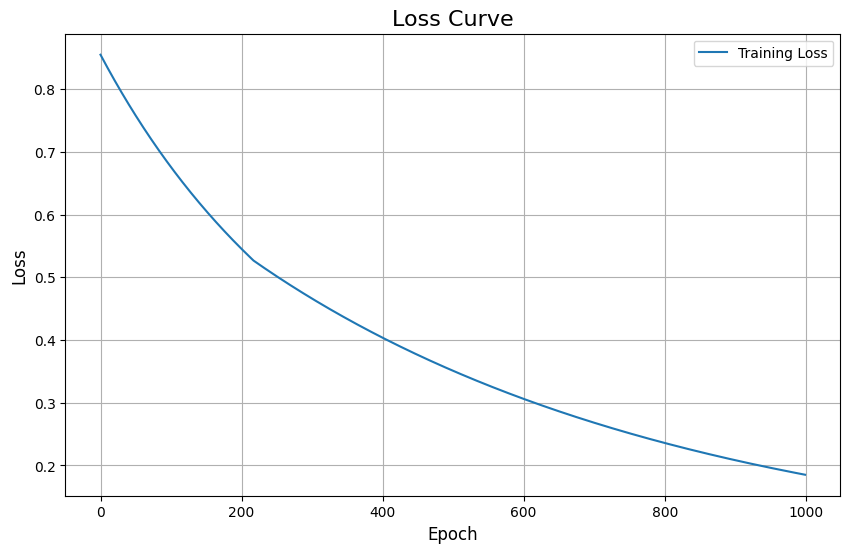

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), loss_history, label='Training Loss')
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

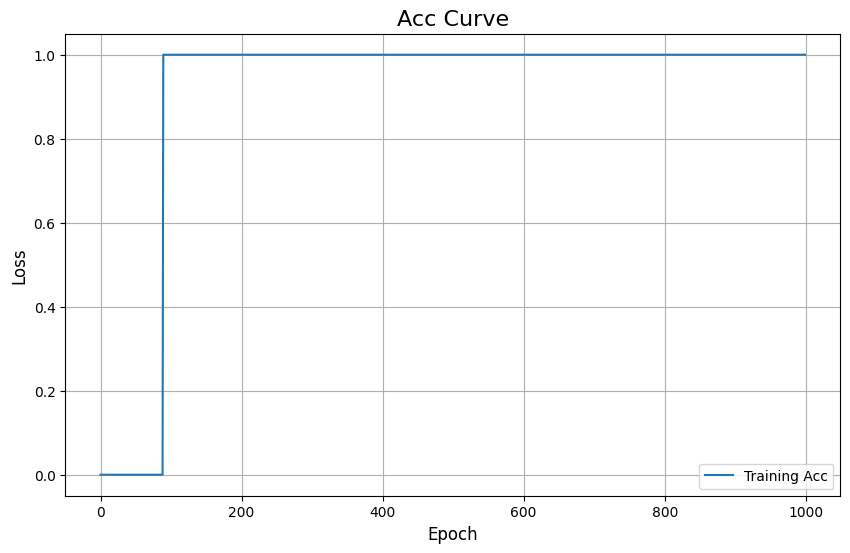

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), acc_history, label='Training Acc')
plt.title('Acc Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)